# HCV
Data Source: 
UCI Machine Learning Repository: https://archive.ics.uci.edu/ml/datasets/HCV+data

Relevant Papers: 

- Lichtinghagen R et al. J Hepatol 2013; 59: 236-42

- Hoffmann G et al. Using machine learning techniques to generate laboratory diagnostic pathways- a case study. J Lab Precis Med 2018; 3: 58-67

In [223]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scikitplot as skplt
import xgboost as xgb
import lightgbm as lgb
import catboost as ctb

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn.model_selection import train_test_split, KFold, cross_val_predict

from functools import partial
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

In [2]:
df = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/00571/hcvdat0.csv")

### Przygotowanie danych

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 615 entries, 0 to 614
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  615 non-null    int64  
 1   Category    615 non-null    object 
 2   Age         615 non-null    int64  
 3   Sex         615 non-null    object 
 4   ALB         614 non-null    float64
 5   ALP         597 non-null    float64
 6   ALT         614 non-null    float64
 7   AST         615 non-null    float64
 8   BIL         615 non-null    float64
 9   CHE         615 non-null    float64
 10  CHOL        605 non-null    float64
 11  CREA        615 non-null    float64
 12  GGT         615 non-null    float64
 13  PROT        614 non-null    float64
dtypes: float64(10), int64(2), object(2)
memory usage: 67.4+ KB


Zbiór danych zawiera 615 instancji i 14 atrybutów. Atrybuty mają charakter liczb naturalnych (Unnamed:0 oraz Age), obiektów tekstowych (Category i Sex)  oraz liczb zmiennoprzecinkowych (ALB-PROT)

In [4]:
df.sample(10)

,Unnamed: 0,Category,Age,Sex,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT
250,251,0=Blood Donor,55,m,41.5,59.5,15.4,16.2,6.8,6.35,5.22,80.0,12.4,69.9
226,227,0=Blood Donor,53,m,45.3,53.0,39.6,31.3,9.6,9.96,7.22,73.0,42.9,78.6
456,457,0=Blood Donor,51,f,38.3,67.7,17.4,19.9,5.4,7.50,4.94,72.0,7.9,69.0
342,343,0=Blood Donor,35,f,41.0,62.6,27.9,12.0,12.8,10.34,5.90,78.0,22.8,76.1
137,138,0=Blood Donor,44,m,44.6,53.9,28.4,23.8,8.8,9.47,4.87,94.0,21.3,69.2
283,284,0=Blood Donor,61,m,34.3,60.5,35.4,26.6,15.2,9.03,7.62,74.0,51.4,76.0
427,428,0=Blood Donor,48,f,32.0,66.3,14.2,21.3,5.5,4.72,5.23,41.0,17.2,65.6
280,281,0=Blood Donor,60,m,45.2,89.4,38.6,27.2,8.6,5.19,6.01,75.0,76.9,74.4
36,37,0=Blood Donor,35,m,41.5,115.1,24.1,30.4,5.7,9.41,4.33,81.0,22.2,71.3
557,558,1=Hepatitis,51,m,43.0,37.2,21.4,132.8,5.0,10.12,5.23,76.2,76.4,76.7


In [5]:
df['Category'].unique()

array(['0=Blood Donor', '0s=suspect Blood Donor', '1=Hepatitis',
       '2=Fibrosis', '3=Cirrhosis'], dtype=object)

W zbiorze danych występuje 5 klas:
- 0 - dawca krwi (pacjent zdrowy),
- 0s - dawca krwi podejrzany o zakażenie HCV,
- 1 - hepatitis (pacjent chory na zapalenie wątroby typu C),
- 2 - fibrosis (pacjent ze zwłóknieniami wątroby),
- 3 - cirrhosis (pacjent z marskością wątroby)

In [6]:
categories = pd.DataFrame(df['Category'].value_counts())

array([<AxesSubplot:ylabel='Category'>], dtype=object)

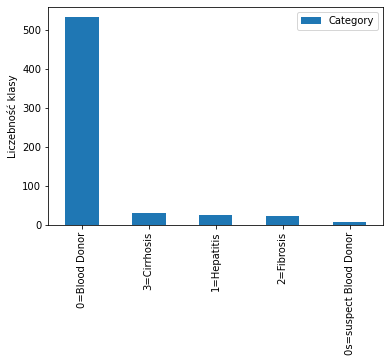

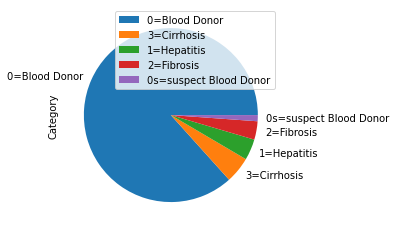

In [15]:
categories.plot.bar(ylabel = 'Liczebność klasy')
categories.plot.pie(subplots=True)


Zbiór danych jest niezbalansowany, zdecydowanie przeważa klasa 0=Blood Donor.

Oprócz klasy w zbiorze występuje 13 atrybutów:
- ID pacjenta,
- wiek,
- płeć (m, f),
- ALB - poziom albuminy,
- ALP - poziom fosfatazy alkalicznej,
- ALT - poziom aminotransferazy alaninowej,
- AST - poziom aminotransferazy asparaginowej,
- BIL - poziom bilirubiny,
- CHE - poziom cholinoesterazy,
- CHOL - poziom cholesterolu,
- CREA - poziom kreatyniny,
- GGT - poziom gammaglutamylotransferazy,
- PROT - poziom białka całkowitego.

In [16]:
#usunięcie kolumny Unnamed:0 zawierającej ID pacjenta, która nie jest istotna w analizie
if 'Unnamed: 0' in df: del df['Unnamed: 0']

In [17]:
#sprawdzenie, czy w zbiorze występują brakujące dane
def check_missing():
    for column in df.columns:
        missing = column, df[column].isnull().sum()
        if missing[1] == 0: continue

        print(missing)
        
check_missing()

('ALB', 1)
('ALP', 18)
('ALT', 1)
('CHOL', 10)
('PROT', 1)


W przypadku niektórych instancji występują braki danych dotyczące pewnych parametrów krwi. Brakujące dane zostaną zastąpione wartościami średnimi tych parametrów.

In [18]:
df.describe()

,Age,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT
count,615.000000,614.000000,597.000000,614.000000,615.000000,615.000000,615.000000,605.000000,615.000000,615.000000,614.000000
mean,47.408130,41.620195,68.283920,28.450814,34.786341,11.396748,8.196634,5.368099,81.287805,39.533171,72.044137
std,10.055105,5.780629,26.028315,25.469689,33.090690,19.673150,2.205657,1.132728,49.756166,54.661071,5.402636
min,19.000000,14.900000,11.300000,0.900000,10.600000,0.800000,1.420000,1.430000,8.000000,4.500000,44.800000
25%,39.000000,38.800000,52.500000,16.400000,21.600000,5.300000,6.935000,4.610000,67.000000,15.700000,69.300000
50%,47.000000,41.950000,66.200000,23.000000,25.900000,7.300000,8.260000,5.300000,77.000000,23.300000,72.200000
75%,54.000000,45.200000,80.100000,33.075000,32.900000,11.200000,9.590000,6.060000,88.000000,40.200000,75.400000
max,77.000000,82.200000,416.600000,325.300000,324.000000,254.000000,16.410000,9.670000,1079.100000,650.900000,90.000000


In [19]:
df=df.fillna({'ALB':df['ALB'].mean(), 'ALP':df['ALP'].mean(), 'ALT':df['ALT'].mean(), 'CHOL':df['CHOL'].mean(), 'PROT':df['PROT'].mean()})

In [20]:
check_missing()

In [224]:
# plt.subplot(6,2,1)
# df['Age'].hist(figsize=(15,15))
# plt.subplot(6,2,2)
# df['ALB'].hist(figsize=(15,15))
# plt.subplot(6,2,3)
# df['ALP'].hist(figsize=(15,15))
# plt.subplot(6,2,4)
# df['ALT'].hist(figsize=(15,15))
# plt.subplot(6,2,5)
# df['AST'].hist(figsize=(15,15))
# plt.subplot(6,2,6)
# df['BIL'].hist(figsize=(15,15))
# plt.subplot(6,2,7)
# df['CHE'].hist(figsize=(15,15))
# plt.subplot(6,2,8)
# df['CHOL'].hist(figsize=(15,15))
# plt.subplot(6,2,9)
# df['CREA'].hist(figsize=(15,15))
# plt.subplot(6,2,10)
# df['GGT'].hist(figsize=(15,15))
# plt.subplot(6,2,11)
# df['PROT'].hist(figsize=(15,15))

In [21]:
#zmiana wartości atrybutów na wartości liczbowe
df['Sex_cat'] = df['Sex'].factorize()[0]  
# m:0, f:1

def category_cat(row):
    if row['Category'] == '0=Blood Donor': return 0
    elif row['Category'] == '1=Hepatitis': return 1
    elif row['Category'] == '2=Fibrosis':return 2
    elif row['Category'] == '3=Cirrhosis': return 3
    else: return 4
df['Category_cat'] = df[['Category']].apply(category_cat, axis=1)

In [22]:
df.sample(10)

,Category,Age,Sex,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT,Sex_cat,Category_cat
444,0=Blood Donor,49,f,45.4,45.9,14.3,15.9,5.8,9.05,6.81,69.0,14.5,78.2,1,0
123,0=Blood Donor,43,m,39.4,61.8,55.0,32.5,7.1,11.94,7.84,64.0,153.5,75.6,0,0
259,0=Blood Donor,57,m,59.7,64.5,17.3,21.2,18.9,12.07,3.97,106.0,15.1,77.6,0,0
166,0=Blood Donor,47,m,42.1,81.6,26.4,26.4,5.5,10.50,5.95,97.0,35.3,77.5,0,0
477,0=Blood Donor,53,f,43.5,61.7,16.9,20.3,7.0,7.19,6.97,74.0,12.3,69.2,1,0
112,0=Blood Donor,42,m,46.4,43.7,18.7,24.3,6.3,6.59,4.78,93.0,10.1,73.1,0,0
12,0=Blood Donor,33,m,36.3,78.6,23.6,22.0,7.0,8.56,5.38,78.0,19.4,68.7,0,0
398,0=Blood Donor,45,f,39.5,92.2,18.7,19.4,3.5,8.32,5.38,85.0,15.8,72.2,1,0
513,0=Blood Donor,59,f,40.0,68.4,13.2,20.3,8.2,9.10,6.38,63.0,16.3,71.9,1,0
349,0=Blood Donor,35,f,46.9,50.8,35.4,22.1,13.1,8.27,5.70,95.0,37.3,80.7,1,0


### Tworzenie modelu

In [126]:
def get_features(df, black_list=['Category_cat','Category_prediction']):
    num_features = df.select_dtypes(np.number).columns
    return [i for i in num_features if i not in black_list]

def get_X_y(df, features=None):
    if features is None:
        features = get_features(df)
        
    X = df[features].values
    y = df['Category_cat'].values
    
    return X, y

X,y = get_X_y(df)
# X - macierz cech używanych w modelu
# y - wektor zmiennej docelowej

In [180]:
def train_and_predict(model, X, y, test_size=0.3):
    X_train, y_train, X_test, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
    
    cv = KFold(n_splits=4, random_state=1, shuffle=True)
    scores=[]
    for train_idx, test_idx in cv.split(y):
        model.fit(X[train_idx], y[train_idx])
        y_pred = model.predict(X[test_idx])
        
    score = accuracy_score(y[test_idx], y_pred)
    scores.append(score)
    
    return print(score),print(classification_report(y[test_idx],y_pred))

In [170]:
#train_and_predict(DummyClassifier(), X, y, test_size=0.3)

In [171]:
#train_and_predict(LogisticRegression(solver='saga', max_iter=10000), X, y, test_size=0.3)

In [348]:
train_and_predict(DecisionTreeClassifier(max_depth=50, random_state=1),X, y, test_size=0.3)

0.6666666666666666
              precision    recall  f1-score   support

           1       0.80      0.89      0.84         9
           2       0.00      0.00      0.00         3
           3       0.67      0.67      0.67         6

    accuracy                           0.67        18
   macro avg       0.49      0.52      0.50        18
weighted avg       0.62      0.67      0.64        18



(None, None)

In [196]:
#train_and_predict(RandomForestClassifier(), X, y, test_size=0.3)

In [173]:
#train_and_predict(ExtraTreesClassifier(), X, y, test_size=0.3)

In [174]:
#train_and_predict(xgb.XGBClassifier(), X, y, test_size=0.3)

In [175]:
#train_and_predict(lgb.LGBMClassifier(), X, y, test_size=0.3)`

In [176]:
#train_and_predict(ctb.CatBoostClassifier(), X, y, test_size=0.3)

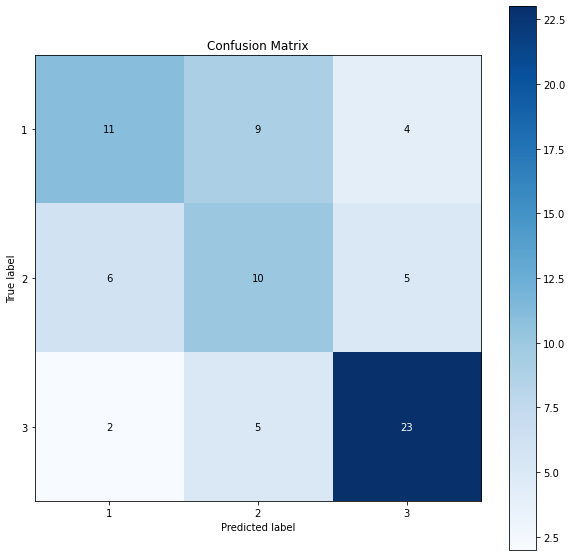

In [350]:
y_pred = cross_val_predict(DecisionTreeClassifier(max_depth=50, random_state=1), X, y, cv=4)
skplt.metrics.plot_confusion_matrix(y, y_pred, normalize=False, figsize=(10 ,10));

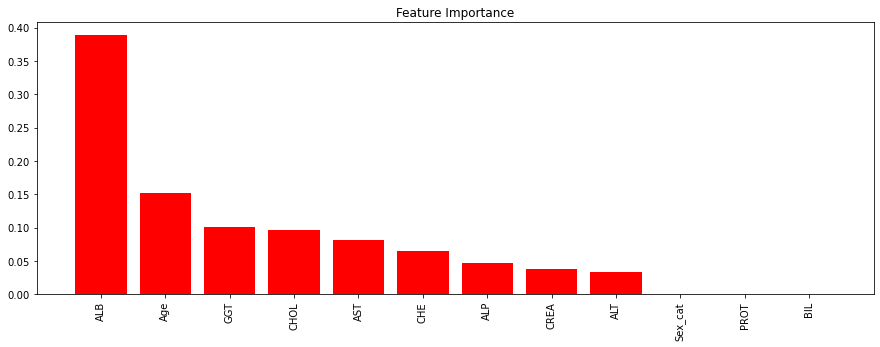

In [351]:
model = DecisionTreeClassifier(max_depth=50, random_state=1)
model.fit(X, y)

feats = get_features(df)
skplt.estimators.plot_feature_importances(model, feature_names=feats, x_tick_rotation=90, figsize=(15, 5));

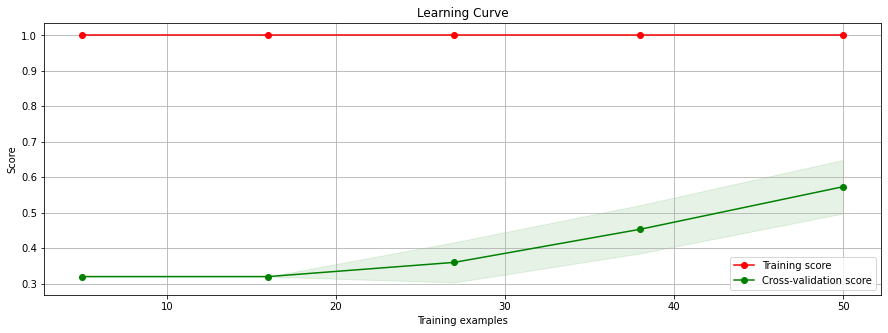

In [352]:
model=DecisionTreeClassifier(max_depth=50, random_state=1)
skplt.estimators.plot_learning_curve(model, X, y, figsize=(15, 5), cv=3, scoring='accuracy');

#### Analiza tylko danych z klas 1, 2 i 3 (tylko pacjenci chorzy)

In [239]:
df2 = df[df['Category'].isin(['1=Hepatitis','2=Fibrosis','3=Cirrhosis'])]

In [241]:
df2.sample(10)

,Category,Age,Sex,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT,Sex_cat,Category_cat
575,2=Fibrosis,64,m,38.0,35.70000,7.1,41.3,13.0,7.10,4.52,70.0,53.0,66.8,0,2
586,3=Cirrhosis,39,m,34.0,137.80000,4.8,35.6,9.0,3.65,4.82,519.0,133.4,57.5,0,3
562,1=Hepatitis,50,f,40.0,32.70000,9.0,46.0,10.0,7.51,4.67,56.6,22.3,70.1,1,1
583,2=Fibrosis,56,f,39.0,68.28392,42.0,34.0,10.0,7.75,5.00,80.0,84.0,78.0,1,2
556,1=Hepatitis,50,m,42.0,41.60000,10.2,38.1,17.0,9.54,7.04,75.3,92.1,72.3,0,1
613,3=Cirrhosis,46,f,33.0,68.28392,39.0,62.0,20.0,3.56,4.20,52.0,50.0,71.0,1,3
545,1=Hepatitis,29,m,49.0,68.28392,53.0,39.0,15.0,8.79,3.60,79.0,37.0,90.0,0,1
541,1=Hepatitis,19,m,41.0,68.28392,87.0,67.0,12.0,7.55,3.90,62.0,65.0,75.0,0,1
568,2=Fibrosis,49,m,39.0,68.28392,118.0,62.0,10.0,7.28,3.50,72.0,74.0,81.0,0,2
602,3=Cirrhosis,61,m,39.0,102.90000,27.3,143.2,15.0,5.38,4.88,72.3,400.3,73.4,0,3


In [316]:
def get_features_2(df2, black_list=['Category_cat','Category_prediction']):
    num_features = df2.select_dtypes(np.number).columns
    return [i for i in num_features if i not in black_list]

def get_X_y_2(df2, features=None):
    if features is None:
        features = get_features(df2)
        
    X = df2[features].values
    y = df2['Category_cat'].values
    
    return X, y

X,y = get_X_y(df2)
# X - macierz cech używanych w modelu
# y - wektor zmiennej docelowej

In [344]:
train_and_predict(DecisionTreeClassifier(max_depth=20, random_state=1),X, y, test_size=0.3)

0.6666666666666666
              precision    recall  f1-score   support

           1       0.80      0.89      0.84         9
           2       0.00      0.00      0.00         3
           3       0.67      0.67      0.67         6

    accuracy                           0.67        18
   macro avg       0.49      0.52      0.50        18
weighted avg       0.62      0.67      0.64        18



(None, None)

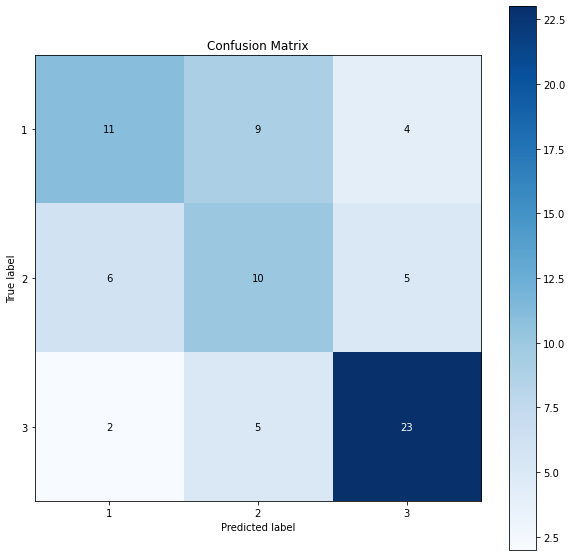

In [345]:
y_pred = cross_val_predict(DecisionTreeClassifier(max_depth=20, random_state=1), X, y, cv=4)
skplt.metrics.plot_confusion_matrix(y, y_pred, normalize=False, figsize=(10 ,10));

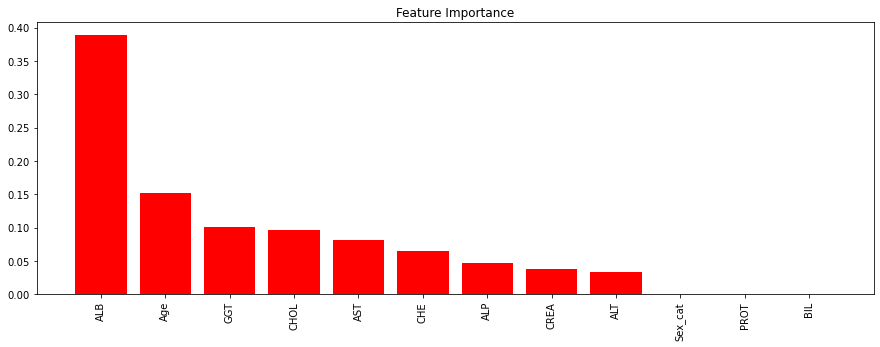

In [346]:
model = DecisionTreeClassifier(max_depth=20, random_state=1)
model.fit(X, y)

feats = get_features(df2)
skplt.estimators.plot_feature_importances(model, feature_names=feats, x_tick_rotation=90, figsize=(15, 5));

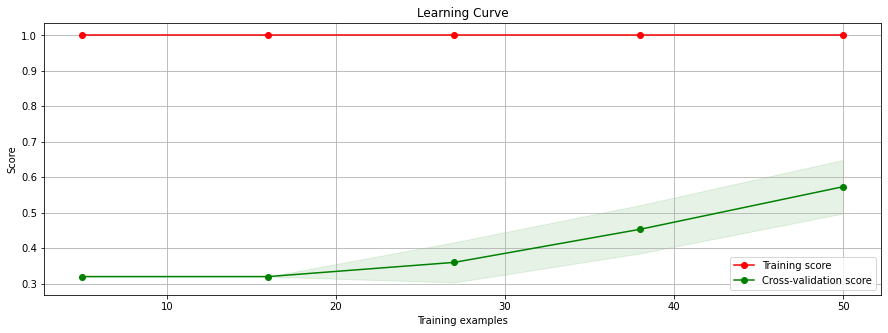

In [347]:
model=DecisionTreeClassifier(max_depth=20, random_state=1)
skplt.estimators.plot_learning_curve(model, X, y, figsize=(15, 5), cv=3, scoring='accuracy');